# Convolution Neural Network 
- pytorch

### Imports

In [1]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Setting and Dataset

In [2]:
# Setting

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# hyperparameters
random_seed = 1
learning_rate = 0.05
num_epochs = 10
batch_size = 128

# Architecture
num_classes = 10

### MNIST DATASET

# note transforms.ToTensor() scales input images
# to 0-1 range

train_dataset = datasets.MNIST(root = 'data',
                              train = True,
                              transform = transforms.ToTensor(),
                              download = True)

test_dataset = datasets.MNIST(root = 'data',
                             train = False,
                             transform  = transforms.ToTensor())


train_loader = DataLoader(dataset = train_dataset,
                         batch_size = batch_size,
                         shuffle = True)

test_laoder = DataLoader(dataset = test_dataset,
                        batch_size = batch_size,
                        shuffle = False)


# checking the dataset
for images, labels in train_loader:
    print("Image batch dimension", images.shape)
    print("Image label dimension", labels.shape)
    break

100%|██████████| 9912422/9912422 [00:00<00:00, 144835854.04it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 21030502.40it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 47032802.40it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14988614.29it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Image batch dimension torch.Size([128, 1, 28, 28])
Image label dimension torch.Size([128])


## Model

In [3]:
## model

class ConvNet(torch.nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        
        # calculate same padding
        # (w - k + 2 *p)/s + 1 = o
        # => p = (s(o-1) - 1 + k ) /2
        
        # 28 x 28 x 1 => 28x28x8
        self.conv_1 = torch.nn.Conv2d(in_channels = 1,
                                     out_channels = 8,
                                     kernel_size = (3,3),
                                     stride = (1,1),
                                     padding = 1) # (1(28-1) -28 + 3)
        
        # 28x28x8 => 14x14x8
        self.pool_1 = torch.nn.MaxPool2d(kernel_size = (2,2),
                                        stride = (2,2),
                                        padding = 0) # (1(14-1) - 28 + 2)
        
        # 14x14x8 => 14x14x16
        self.conv_2 = torch.nn.Conv2d(in_channels = 8,
                                     out_channels = 16,
                                     kernel_size = (3,3),
                                     stride = (1,1),
                                     padding = 1) # (1(14-1) - 14 + 3)
        
        # 14x14x16 => 7x7x16
        self.pool_2 = torch.nn.MaxPool2d(kernel_size = (2,2),
                                        stride = (2,2),
                                        padding = 0) # (2 (7-1) - 7 + 3)
        
        self.Linear_1 = torch.nn.Linear(7*7*16, num_classes)
        
        #optinally initialize weights from Gaussian
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
                m.weight.data.normal_(0.0, 0.01)
                m.bias.data.zero_()
                if m.bias is not None:
                    m.bias.detach().zero_()
                    
                    
    def forward(self, x):
        out = self.conv_1(x)
        out = F.relu(out)
        out = self.pool_1(out)
        
        out = self.conv_2(out)
        out = F.relu(out)
        out = self.pool_2(out)
        
        logits = self.Linear_1(out.view(-1, 7*7*16))
        probas = F.softmax(logits, dim = 1)
        return logits, probas
    
    
torch.manual_seed(random_seed)
model = ConvNet(num_classes = num_classes)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
        
 
        

In [4]:
model

ConvNet(
  (conv_1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (Linear_1): Linear(in_features=784, out_features=10, bias=True)
)

## Training

In [5]:
def compute_accuracy(model , data_loader):
    correct_pred , num_examples = 0,0
    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float() / num_examples * 100


start_time = time.time()
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(device)
        targets = targets.to(device)
        
        ## forward and back prop
        logits , probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ## update the model parameters
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
    
    model = model.eval()
    print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
          epoch+1, num_epochs, 
          compute_accuracy(model, train_loader)))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
        
        
        

Epoch: 001/010 | Batch 000/469 | Cost: 2.3026
Epoch: 001/010 | Batch 050/469 | Cost: 2.2991
Epoch: 001/010 | Batch 100/469 | Cost: 2.2996
Epoch: 001/010 | Batch 150/469 | Cost: 2.2982
Epoch: 001/010 | Batch 200/469 | Cost: 2.3028
Epoch: 001/010 | Batch 250/469 | Cost: 2.2980
Epoch: 001/010 | Batch 300/469 | Cost: 2.3024
Epoch: 001/010 | Batch 350/469 | Cost: 2.3009
Epoch: 001/010 | Batch 400/469 | Cost: 2.2967
Epoch: 001/010 | Batch 450/469 | Cost: 2.2740
Epoch: 001/010 training accuracy: 32.33%
Time elapsed: 0.44 min
Epoch: 002/010 | Batch 000/469 | Cost: 2.2203
Epoch: 002/010 | Batch 050/469 | Cost: 1.1178
Epoch: 002/010 | Batch 100/469 | Cost: 0.8913
Epoch: 002/010 | Batch 150/469 | Cost: 0.5937
Epoch: 002/010 | Batch 200/469 | Cost: 0.4591
Epoch: 002/010 | Batch 250/469 | Cost: 0.2613
Epoch: 002/010 | Batch 300/469 | Cost: 0.3218
Epoch: 002/010 | Batch 350/469 | Cost: 0.2371
Epoch: 002/010 | Batch 400/469 | Cost: 0.2065
Epoch: 002/010 | Batch 450/469 | Cost: 0.1441
Epoch: 002/010 t

## Evaluation

In [6]:
with torch.set_grad_enabled(False): # save the memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_laoder)))
    

Test accuracy: 98.26%


In [8]:
with torch.set_grad_enabled(False): # save the memory during inference
    print('Train accuracy: %.2f%%' % (compute_accuracy(model, train_loader)))

Train accuracy: 98.28%


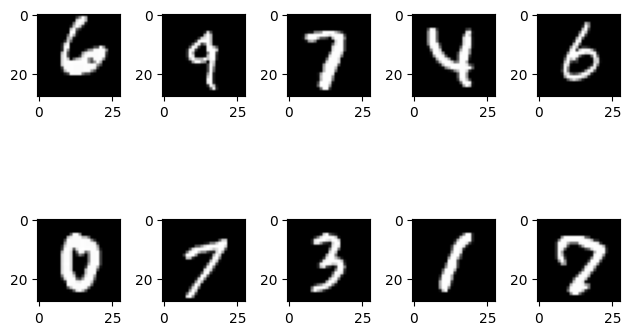

In [9]:
import matplotlib.pyplot as plt

for i, f in enumerate(features[:10]): 
    plt.subplot(2,5,i + 1)
    plt.imshow(f[0].numpy().reshape(28,28), cmap = 'gray')
    
plt.tight_layout()
plt.show()
